### Import all dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import print_function, division
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import time
from tensorflow.keras.layers import Input,Dense,Conv2D,Conv3D,DepthwiseConv2D,SeparableConv2D,Conv3DTranspose
from tensorflow.keras.layers import Flatten,MaxPool2D,AvgPool2D,GlobalAvgPool2D,UpSampling2D,BatchNormalization
from tensorflow.keras.layers import Concatenate,Add,Dropout,ReLU,Lambda,Activation,LeakyReLU,PReLU
import tensorflow.keras.backend as K
from IPython.display import SVG
from tensorflow.keras.preprocessing import image
from time import time


### Define Few Parameters

In [3]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 100
batch_size = 32
import os
#define paths
covid_path = '/content/drive/MyDrive/CovidDataset/COVID POSITIVE'
noncovid_path = '/content/drive/MyDrive/CovidDataset/COVID NEGATIVE'

# Use glob to grab images from path .jpg or jpeg
covid_files = os.listdir(covid_path + '/')
noncovid_files = os.listdir(noncovid_path + '/')

### Fetch Images and Class Labels from Files (This might take a while)

In [4]:
# Preparing Labels
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

import cv2 

for i in range(len(covid_files)):
  image = cv2.imread(covid_path+'/'+covid_files[i])
  image = cv2.resize(image,(224,224))
  covid_images.append(image)
  covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_path+'/'+noncovid_files[i])
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('Chest_NonCOVID')

### Visualize First 40 Images from Data set

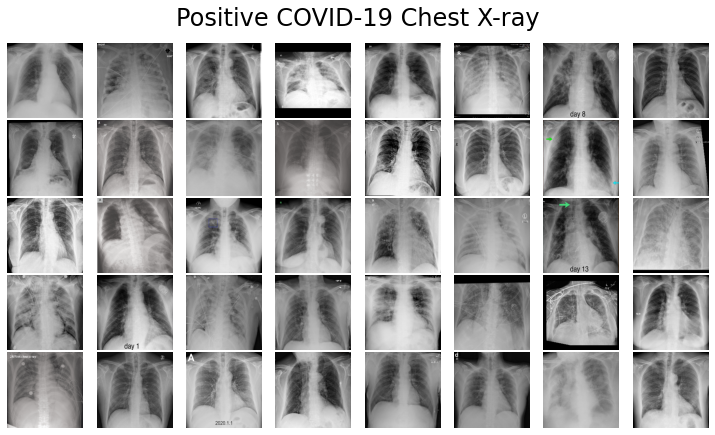

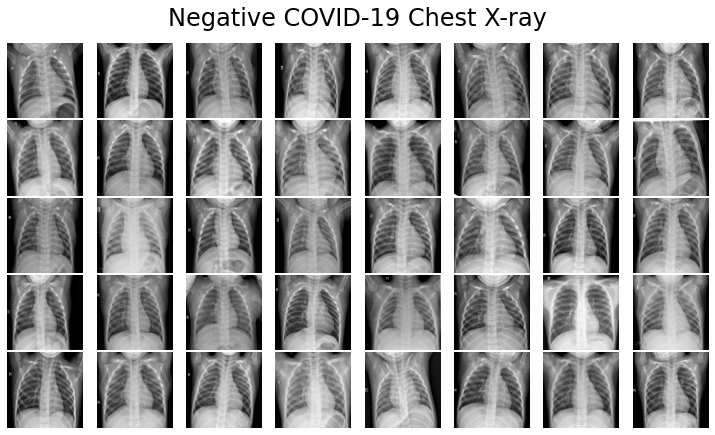

In [5]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'Positive COVID-19 Chest X-ray')
plot_images(noncovid_images, 'Negative COVID-19 Chest X-ray')

### **Normalization**
#### Model takes images in the form of array of pixels. Hence convert into array and *normalize*

In [6]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

### **Train Test Split**

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [8]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((226, 224, 224, 3), (58, 224, 224, 3), (226, 2), (58, 2))

### Visualize a few images from Training and Test sets

### **Building and Visualizing model**

# MobileNet

In [9]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((226, 224, 224, 3), (58, 224, 224, 3), (226, 2), (58, 2))

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Conv1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
def model_b():
    new_input = Input(shape=(X_train.shape[1],X_train.shape[2], 3))
    i1 = tf.keras.applications.MobileNet(include_top=False,weights="imagenet",input_tensor=new_input,
                        input_shape=None,
                         pooling=None,
                    )(new_input)
    i1 = tf.keras.layers.Flatten()(i1)
    class1 = Dense(1024, activation='relu')(i1)
    class1 = Dense(256, activation='relu')(class1)
    class1 = Dense(128, activation='relu')(class1)
    class1 = Dense(64, activation='relu')(class1)
    output = Dense(2, activation='sigmoid')(class1)
    model = Model(inputs=new_input, outputs=output)
    return model
md = model_b()
md.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 1024)              51381248  
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dense_2 (Dense)             (None, 128)               32896  

In [11]:
model = model_b()
METRICS = [
               'accuracy',tf.keras.metrics.Recall(name = 'recall'),
                tf.keras.metrics.Precision(name = 'precision')
        ]  
model.compile(
                optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=METRICS
            )
history = model.fit(X_train, y_train, epochs=100,verbose=1,shuffle = True,validation_data=(X_test,y_test))

Epoch 1/100
8/8 [==============================] - 17s 383ms/step - loss: 4.1307 - accuracy: 0.7965 - recall: 0.9159 - precision: 0.5864 - val_loss: 2.1893 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 2/100
8/8 [==============================] - 1s 177ms/step - loss: 0.9016 - accuracy: 0.9867 - recall: 1.0000 - precision: 0.6278 - val_loss: 19.8726 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 3/100
8/8 [==============================] - 1s 179ms/step - loss: 0.5247 - accuracy: 0.9912 - recall: 1.0000 - precision: 0.6570 - val_loss: 0.6142 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 4/100
8/8 [==============================] - 1s 178ms/step - loss: 0.0369 - accuracy: 0.9956 - recall: 1.0000 - precision: 0.6608 - val_loss: 19.2424 - val_accuracy: 0.5000 - val_recall: 1.0000 - val_precision: 0.5000
Epoch 5/100
8/8 [==============================] - 1s 180ms/step - loss: 2.1099e-09 - accuracy: 0.9912 - 

In [12]:
y_pred = model.predict(X_test, batch_size=batch_size)

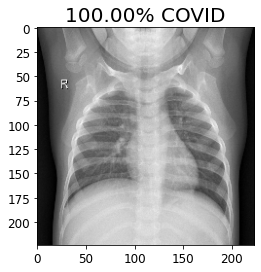

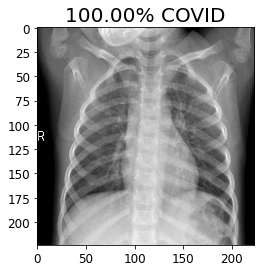

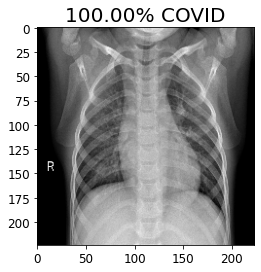

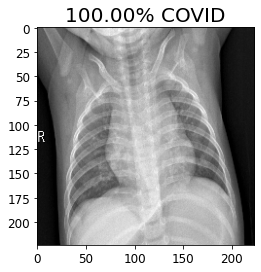

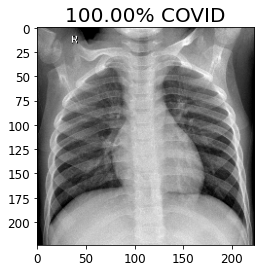

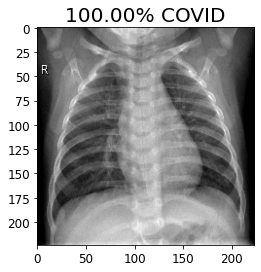

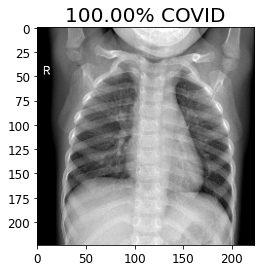

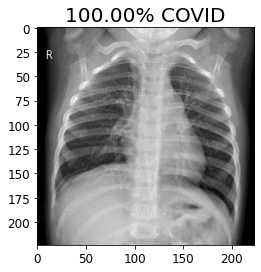

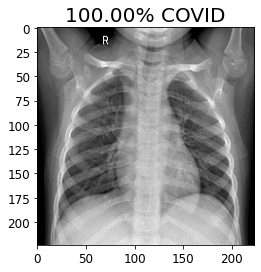

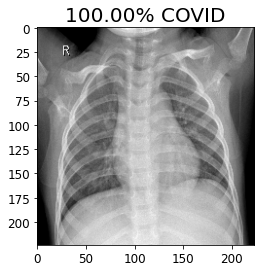

In [27]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID',fontsize=20)
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID',fontsize=20)
  plt.imshow(X_test[index])
  plt.show()

In [14]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

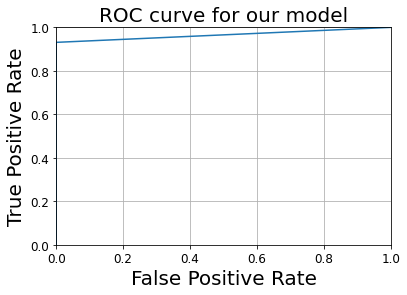

In [25]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=20)
plt.grid(True)

Confusion Matrix without Normalization


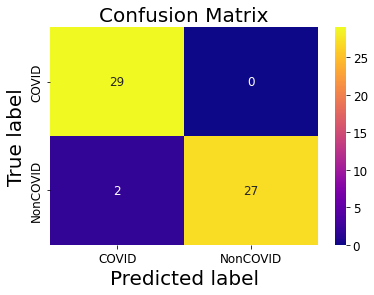

Confusion Matrix with Normalized Values


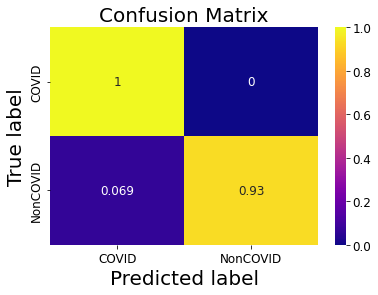

In [24]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix',fontsize=20)
  plt.ylabel('True label',fontsize=20)
  plt.xlabel('Predicted label',fontsize=20)
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        29
           1       1.00      0.93      0.96        29

    accuracy                           0.97        58
   macro avg       0.97      0.97      0.97        58
weighted avg       0.97      0.97      0.97        58



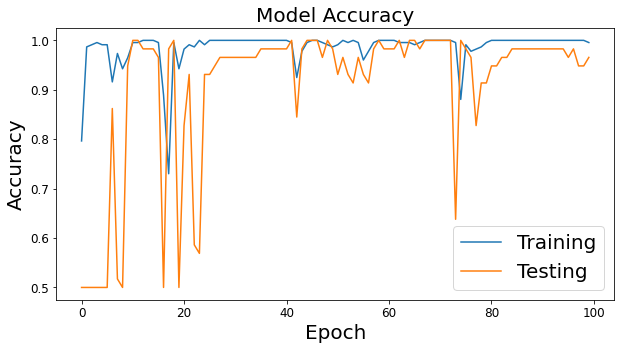

In [23]:
plt.figure(figsize=(10,5))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy',fontsize=20)
plt.ylabel('Accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=20)

plt.legend(['Training', 'Testing'],fontsize=20)
plt.savefig('vgg_chest_accuracy.png')
plt.show()


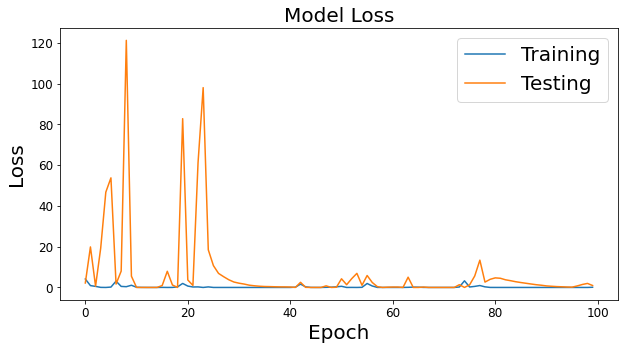

In [22]:
plt.figure(figsize=(10,5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss',fontsize=20)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)

plt.legend(['Training', 'Testing'],fontsize=20)
plt.savefig('vgg_chest_loss.png')
plt.show()

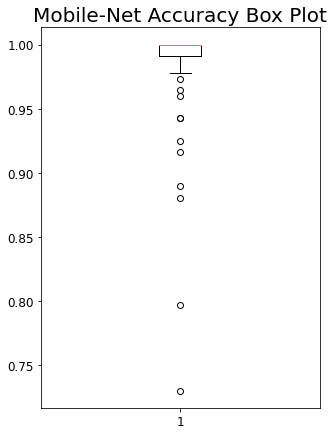

In [21]:
plt.figure(figsize=(5,7))
plt.boxplot(history.history['accuracy'])
plt.title("Mobile-Net Accuracy Box Plot",fontsize=20)
plt.show()